# ---------------------------------
# 🧬 Step : DESeq2 Analysis via R (rpy2)
# ---------------------------------

# Activate R ↔ pandas conversion

In [1]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

pandas2ri.activate()

In [2]:
ro.r('''
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("DESeq2")
''')

(as ‘lib’ is unspecified)







	‘/tmp/RtmpI4k5MO/downloaded_packages’

'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

































	‘/tmp/RtmpI4k5MO/downloaded_packages’




Update all/some/none? [a/s/n]: a








	‘/tmp/RtmpI4k5MO/downloaded_packages’



In [3]:
ro.r("""BiocManager::install("apeglm")
install.packages("tidyr")
install.packages("ggplot2")
install.packages("matrixStats") """)


'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com
















	‘/tmp/RtmpI4k5MO/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpI4k5MO/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpI4k5MO/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpI4k5MO/downloaded_packages’



In [4]:
import os
os.makedirs("results/qc_plots", exist_ok=True)
os.makedirs("scripts", exist_ok=True)

%load_ext rpy2.ipython

import rpy2.robjects as ro
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()


In [5]:
pip install pydeseq2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.4/255.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.9 MB/s eta 0:00:00


In [6]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [7]:
# Load R packages
deseq2 = importr("DESeq2")
apeglm = importr("apeglm")
base = importr("base")
utils = importr("utils")
ro.r('library(tidyr)')
ro.r('library(ggplot2)')
ro.r('library(matrixStats)')

Attaching package: ‘tidyr’



    expand




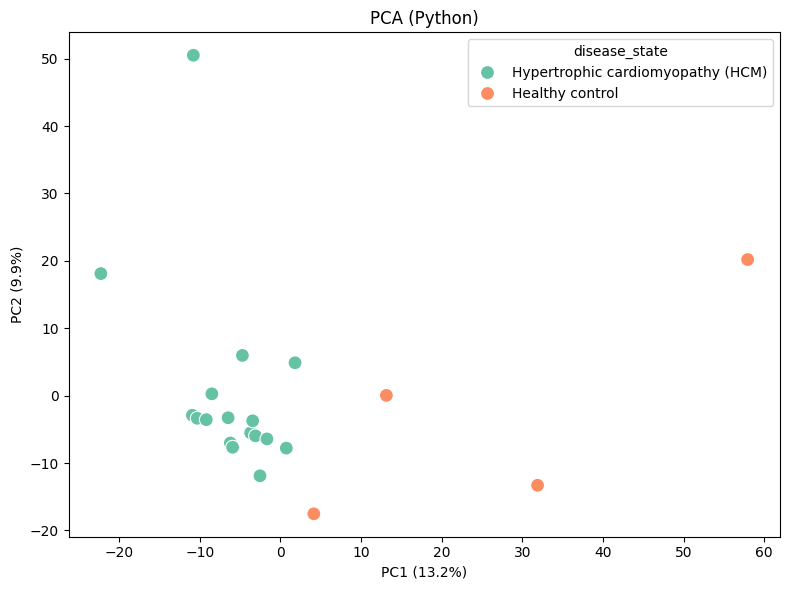

/usr/local/lib/python3.11/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Bases". Fall back to string conversion. The error is: integer 4738723454 does not fit 'int'
  warnings.warn('Error while trying to convert '
/usr/local/lib/python3.11/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "Bytes". Fall back to string conversion. The error is: integer 2517562046 does not fit 'int'
  warnings.warn('Error while trying to convert '
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]







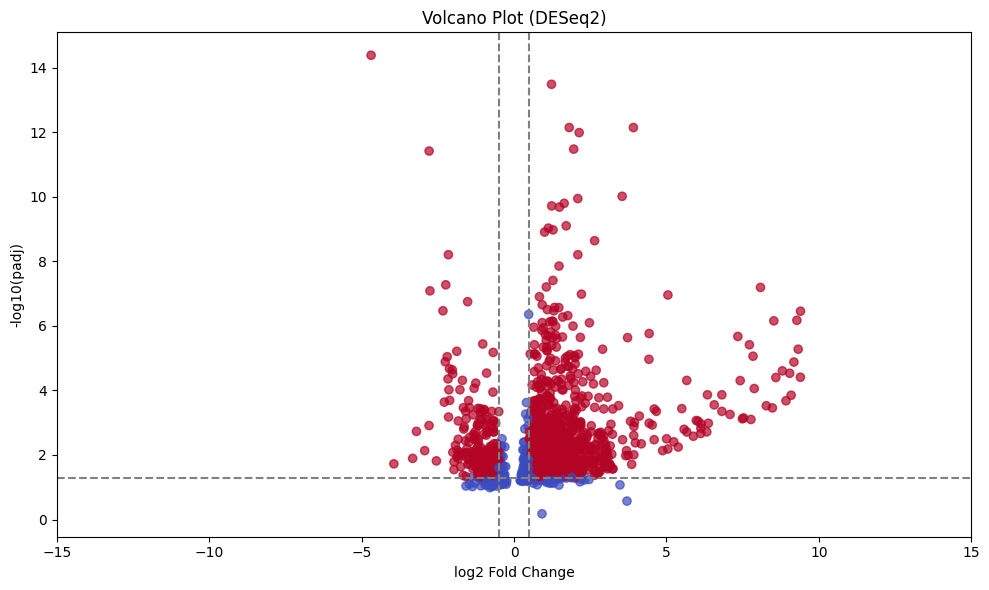

In [9]:
# RNA-seq Pipeline: Python preprocessing + R DESeq2 (via rpy2)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

# 1. Load and filter data in Python
counts_df = pd.read_csv("GSE160997_gencodev48_count_matrix.csv").set_index("Transcript_IDs")
meta = pd.read_csv("SraRunTable.csv")

# Filter low-expressed genes
filtered = counts_df.loc[(counts_df > 5).sum(axis=1) >= 3]
outliers = ["GSM4887615", "GSM4887610"]
filtered = filtered.drop(columns=outliers, errors="ignore")
filtered.to_csv("counts_filtered_final.csv")

# Log2 for PCA
log_counts = np.log2(filtered + 1)
meta = meta.set_index("Sample Name")
meta_matched = meta.loc[log_counts.columns]
meta_matched.to_csv("meta_matched.csv")

# PCA with top 1000 variable genes
variances = log_counts.var(axis=1)
top_genes = variances.sort_values(ascending=False).head(1000).index
log_counts_top = log_counts.loc[top_genes]

scaled = RobustScaler().fit_transform(log_counts_top.fillna(0).T)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled)

pca_df = pd.DataFrame(pca_results, columns=["PC1", "PC2"], index=log_counts.columns)
pca_df = pd.concat([pca_df, meta_matched], axis=1)

os.makedirs("results/qc_plots", exist_ok=True)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"], hue=pca_df["disease_state"], palette="Set2", s=100)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA (Python)")
plt.tight_layout()
plt.savefig("results/qc_plots/pca_python_final.png", dpi=300)
plt.show()

# 2. Run DESeq2 in R (no further filtering)
counts = pd.read_csv("counts_filtered_final.csv", index_col=0).fillna(0).astype(int)
meta = pd.read_csv("meta_matched.csv", index_col=0)
meta["condition"] = meta["disease_state"].str.strip()
meta = meta.loc[counts.columns]

r_counts = pandas2ri.py2rpy(counts)
r_meta = pandas2ri.py2rpy(meta)
ro.globalenv["countData"] = r_counts
ro.globalenv["colData"] = r_meta

# 2. Run DESeq2 in R (no further filtering)
ro.r("""library(DESeq2)
library(apeglm)
library(matrixStats)
library(ggplot2)

# === Δημιουργία DESeq2 αντικειμένου ===
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ condition)

# === Estimate size factors + VST ===
dds <- estimateSizeFactors(dds, type = "poscounts")
vsd <- vst(dds, blind = TRUE)
vst_counts <- assay(vsd)
write.csv(vst_counts, file = "results/vst_counts.csv")

# === DESeq analysis ===
dds <- DESeq(dds)

# === Log2 fold-change shrinkage με apeglm ===
resLFC <- lfcShrink(dds, coef=2, type="apeglm")

# === Αφαίρεση γραμμών με NA σε padj ή log2FoldChange ===
resLFC <- resLFC[!is.na(resLFC$padj) & !is.na(resLFC$log2FoldChange), ]

# === Φιλτράρισμα: περιορισμός log2FC και επιλογή σημαντικών ===
resLFC <- resLFC[abs(resLFC$log2FoldChange) <= 10, ]
resSig <- resLFC[resLFC$padj < 0.05 & abs(resLFC$log2FoldChange) > 0.5, ]

# === Αποθήκευση αποτελεσμάτων ===
write.csv(as.data.frame(resLFC), file = "results/deseq2_results.csv")
write.csv(as.data.frame(resSig), file = "results/deseq2_significant.csv")
""")

# 3. Volcano plot in Python
res = pd.read_csv("results/deseq2_results.csv", index_col=0)
res["padj"] = res["padj"].replace(0, np.nan)
res = res.dropna(subset=["padj", "log2FoldChange"])

res = res[res["log2FoldChange"].abs() > 0.01]
plt.figure(figsize=(10,6))
plt.scatter(res["log2FoldChange"], -np.log10(res["padj"]),
            c=(res["padj"] < 0.05) & (abs(res["log2FoldChange"]) > 0.5),
            cmap="coolwarm", alpha=0.7)

plt.axhline(-np.log10(0.05), color='gray', linestyle='--')
plt.axvline(-0.5, color='gray', linestyle='--')
plt.axvline(0.5, color='gray', linestyle='--')
plt.xlim(-15, 15)
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10(padj)")
plt.title("Volcano Plot (DESeq2)")
plt.tight_layout()
plt.savefig("results/qc_plots/volcano_plot_final.png", dpi=300)
plt.show()


In [11]:
padj_thresh = 0.05
logfc_thresh = 1

significant = res[res['padj'] < padj_thresh]

significant = res[res['padj'] < padj_thresh]
upregulated = significant[significant['log2FoldChange'] > logfc_thresh]
downregulated = significant[significant['log2FoldChange'] < -logfc_thresh]

# Εκτύπωση σημαντικών γονιδίων
print("Upregulated genes:")
print(upregulated[['log2FoldChange', 'padj']].head(10))

print("\nDownregulated genes:")
print(downregulated[['log2FoldChange', 'padj']].head())

upregulated.to_csv("genes_up_in_HCM_LFC1.txt", columns=["log2FoldChange", "padj"])
downregulated.to_csv("genes_up_in_Control_LFC1.txt", columns=["log2FoldChange", "padj"])

print(f"Upregulated (HCM): {len(upregulated)}")
print(f"Downregulated (Controls): {len(downregulated)}")

Upregulated genes:
                                         log2FoldChange      padj
ENST00000341832.11|OTTHUMT00000444101.5        1.070776  0.019560
ENST00000401095.9|OTTHUMT00000001290.10        5.241233  0.003909
ENST00000377663.3|OTTHUMT00000004189.1         1.042607  0.002736
ENST00000377532.8|OTTHUMT00000003606.1         1.795547  0.006876
ENST00000476556.5|OTTHUMT00000004918.2         3.859760  0.019507
ENST00000656437.1|OTTHUMT00000505362.1         1.756761  0.004173
ENST00000602477.1|OTTHUMT00000467543.1         5.005871  0.003152
ENST00000294485.6|OTTHUMT00000006325.2         1.672475  0.011323
ENST00000641820.1|OTTHUMT00000493060.1         7.841670  0.000009
ENST00000376576.3|OTTHUMT00000006857.1         1.304467  0.005838

Downregulated genes:
                                         log2FoldChange      padj
ENST00000695738.1                             -1.663025  0.000343
ENST00000294507.4|OTTHUMT00000010463.2        -2.011230  0.000030
ENST00000371045.9|OTTHUMT0000002519